## Simulation of State Task Networks

## Model 1: Straightforward Approach

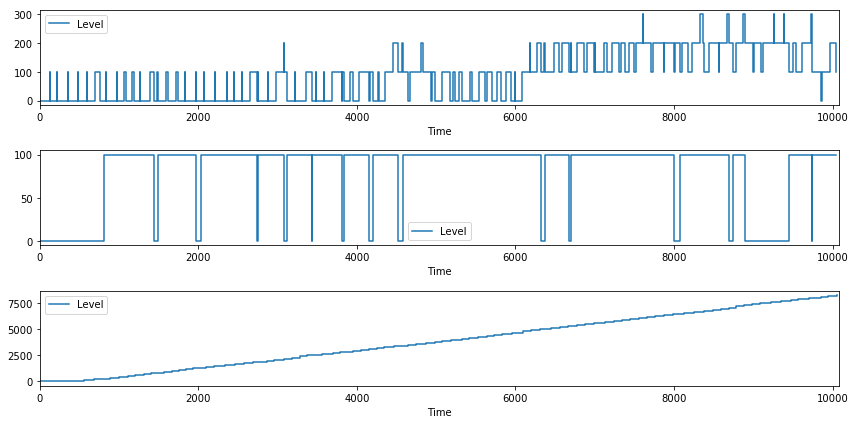

In [160]:
%matplotlib inline

import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt

env = simpy.Environment()

# Time Horizon
H = 7*1440

# States
Feed = simpy.Container(env)
FeedLog = [[0,0]]
Storage = simpy.Container(env,capacity = 100)
StorageLog = [[0,0]]
Product = simpy.Container(env)
ProductLog = [[0,0]]

# choice of random number generator
rand = random.uniform

def FeedDelivery(env):
    while True:
        yield env.timeout(115 + rand(-30,30))
        Feed.put(100)
        FeedLog.append([env.now,Feed.level])
        
def Reactor(env,name):
    while True:
        yield Feed.get(100)
        FeedLog.append([env.now,Feed.level])
        yield env.timeout(335 + rand(-60,60))
        yield Storage.put(100)
        StorageLog.append([env.now,Storage.level])
        
def Still(env):
    while True:
        yield Storage.get(100)
        yield env.timeout(110 + rand(-25,25))
        yield Product.put(100)
        ProductLog.append([env.now,Product.level])
        
env.process(FeedDelivery(env))
env.process(Reactor(env,"1"))
env.process(Reactor(env,"2"))
env.process(Reactor(env,"3"))
env.process(Still(env))
env.run(until=H)

plt.figure(figsize=(12,6))
ax = plt.subplot(3,1,1)
df = pd.DataFrame(FeedLog, columns = ['Time','Level']).set_index('Time')
df.plot(ax=ax,drawstyle='steps-post', xlim=(0,H))

ax = plt.subplot(3,1,2)
df = pd.DataFrame(StorageLog, columns = ['Time','Level']).set_index('Time')
df.plot(ax=ax,drawstyle='steps-post', xlim=(0,H))

ax = plt.subplot(3,1,3)
df = pd.DataFrame(ProductLog, columns = ['Time','Level']).set_index('Time')
df.plot(ax=ax,drawstyle='steps-post', xlim=(0,H))

plt.tight_layout()

## Model 2: Encapsulate State as an Class

In [458]:
import matplotlib.pyplot as plt
import pandas as pd
import simpy

class state(object):
    def __init__(self, env, name, capacity=float("inf"), init=0):
        self.name = name
        self.init = init
        self.capacity = capacity
        self.env = env
        self.container = simpy.Container(env,capacity=capacity,init=init)
        self.log = [[0,0]]
        
    def put(self,amt):
        ret = self.container.put(amt)
        self.log.append([env.now,self.level])
        return ret
        
    def get(self,amt):
        ret = self.container.get(amt)
        self.log.append([env.now,self.level])
        return ret
        
    @property
    def level(self):
        return self.container.level
    
    def plot(self):
        ax = plt.gca()
        df = pd.DataFrame(self.log, columns = ['Time','Level'])
        df = df.set_index('Time')
        df.plot(ax=ax,drawstyle='steps-post')

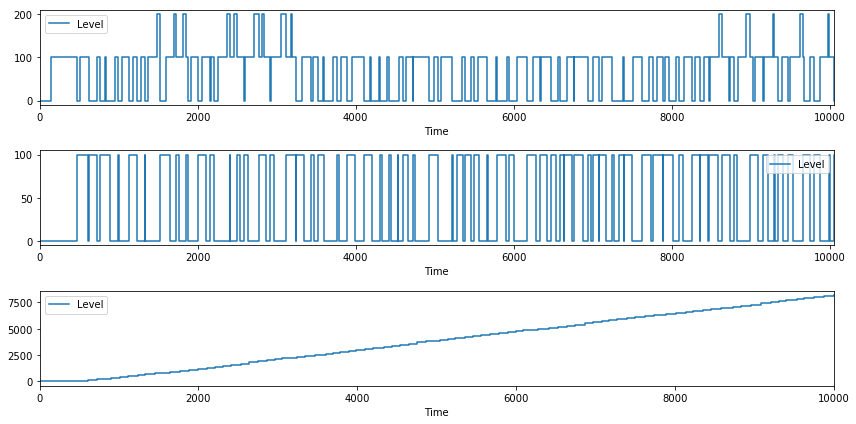

In [231]:
%matplotlib inline

import simpy
import random

env = simpy.Environment()

# Time Horizon
H = 7*1440

# States
Feed = state(env,"Feed")
Storage = state(env,"Storage",capacity=100)
Product = state(env,"Product")

# choice of random number generator
rand = random.uniform

def FeedDelivery(env):
    while True:
        yield env.timeout(115 + rand(-30,30))
        Feed.put(100)
        
def Reactor(env,name,capacity=100):
    while True:
        yield Feed.get(100)
        yield env.timeout(335 + rand(-60,60))
        yield Storage.put(100)
        
def Still(env):
    while True:
        yield Storage.get(100)
        yield env.timeout(110 + rand(-25,25))
        yield Product.put(100)
        
env.process(FeedDelivery(env))
env.process(Reactor(env,"1"))
env.process(Reactor(env,"2"))
env.process(Reactor(env,"3"))
env.process(Still(env))
env.run(until=H)

plt.figure(figsize=(12,6))
ax = plt.subplot(3,1,1)
Feed.plot()

ax = plt.subplot(3,1,2)
Storage.plot()

ax = plt.subplot(3,1,3)
Product.plot()

plt.tight_layout()

## Model 3: Allow for Variable Batch Size

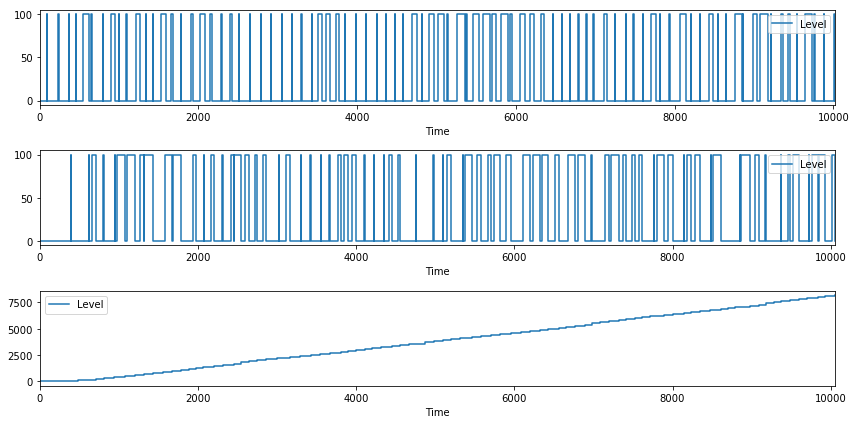

In [293]:
%matplotlib inline

import simpy
import random

env = simpy.Environment()

# Time Horizon
H = 7*1440

# States
Feed = state(env,"Feed",capacity=100)
Storage = state(env,"Storage",capacity=100)
Product = state(env,"Product")

# choice of random number generator
rand = random.uniform

def FeedDelivery(env):
    while True:
        yield env.timeout(115 + rand(-30,30))
        yield Feed.put(100)
        
def Reactor(env,name,cap_min,cap_max):
    while True:
        if (Feed.level > 0) and (Feed.level >= cap_min):
            batch = min(Feed.level,cap_max)
            yield Feed.get(batch)
            yield env.timeout(335 + rand(-60,60))
            yield Storage.put(batch)
        else:
            yield env.timeout(1)

def Still(env,name,cap_min,cap_max):
    while True:
        if (Storage.level > 0) and (Storage.level >= cap_min):
            batch = min(Storage.level,cap_max)
            yield Storage.get(batch)
            yield env.timeout(110 + rand(-25,25))
            yield Product.put(batch)
        else:
            yield env.timeout(1)
        
env.process(FeedDelivery(env))
env.process(Reactor(env,"Reactor 1",50,200))
env.process(Reactor(env,"Reactor 2",50,200))
env.process(Reactor(env,"Reactor 3",50,200))
env.process(Still(env,"Still",100,200))
env.run(until=H)

plt.figure(figsize=(12,6))
ax = plt.subplot(3,1,1)
Feed.plot()

ax = plt.subplot(3,1,2)
Storage.plot()

ax = plt.subplot(3,1,3)
Product.plot()

plt.tight_layout()

## Model 4: STN Models

In [801]:
from pyomo.environ import *
from pprint import pprint
import numpy as np

class STN(object):
    
    def __init__(self):
        # simulation objects
        self.states = set()         # set of state names
        self.tasks = set()          # set of task names
        self.units = set()          # set of unit names

        # dictionaries indexed by task name
        self.S = {}                 # sets of states feeding each task (inputs)
        self.S_ = {}                # sets of states fed by each task (outputs)
        self.K = {}                 # sets of units capable of each task 
        self.p = {}                 # task durations
        
        # dictionaries indexed by state name
        self.T = {}                 # sets of tasks fed from each state (task output)
        self.T_ = {}                # sets of tasks feeding each state (task inputs)
        self.C = {}                 # capacity of each task
        self.init = {}              # initial level
        self.price = {}             # prices of each state
        
        # dictionaries indexed by (task,state) tuples
        self.rho = {}               # input feed fractions indexed by (task,state)
        self.rho_ = {}              # output product dispositions by (task,state)
        self.P = {}                 # time to finish output from task to state (task, state)

        # dictionary indexed by unit
        self.I = {}                 # sets of tasks performed by each unit
        
        # characterization of units indexed by (task,unit)
        self.Vmax = {}              # max capacity of unit j performing tank i
        self.Vmin = {}              # minimum capacity of unit j performing task i
    
    # defines states as .state(name, capacity, init)
    def state(self, name, capacity=float('inf'), init=0, price=0,):
        self.states.add(name)       # add to the set of states
        self.C[name] = capacity     # state capacity
        self.init[name] = init      # state initial value
        self.T[name] = set()        # set of tasks which feed this state (inputs)
        self.T_[name] = set()       # set of tasks fed from this state (outputs)
        self.price[name] = price    # per unit price of each state
        
    def task(self, name):
        self.tasks.add(name)        # add to set of tasks
        self.S[name] = []           # set of states which feed this task (inputs)
        self.S_[name] = []          # set of states fed by this task (outputs)
        self.p[name] = 0            # completion time for this task
        self.K[name] = []
        
    def unit(self, name):
        self.units.add(name)
        self.I[name] = []
        
    def STarc(self,state,task,rho=1):
        if state not in self.states:
            self.state(state)
        if task not in self.tasks:
            self.task(task)
        self.S[task].append(state)  
        self.rho[(task,state)] = rho
        self.T[state].add(task)
        
    def TSarc(self,task,state,rho=1,dur=1):
        if state not in self.states:
            self.state(state)
        if task not in self.tasks:
            self.task(task)
        self.S_[task].append(state)
        self.T_[state].add(task)
        self.rho_[(task,state)] = rho
        self.P[(task,state)] = dur
        self.p[task] = max(self.p[task],dur)
        
    def Unit(self,unit,task,Vmin,Vmax):
        if unit not in self.units:
            self.unit(unit)
        if task not in self.tasks:
            self.task(task)
        self.I[unit].append(task)
        self.K[task].append(unit)
        self.Vmin[(task,unit)] = Vmin
        self.Vmax[(task,unit)] = Vmax
        
    def pprint(self):
        for task in sorted(self.tasks):
            print('\nTask:', task)
            print('    S[{0:s}]:'.format(task), self.S[task])
            print('    S_[{0:s}]:'.format(task), self.S_[task])
            print('    K[{0:s}]:'.format(task), self.K[task])
            print('    p[{0:s}]:'.format(task), self.p[task])

        for state in sorted(self.states):
            print('\nState:', state)
            print('    T[{0:s}]:'.format(state), self.T[state])
            print('    T_[{0:s}]:'.format(state), self.T_[state])
            print('    C[{0:s}]:'.format(state), self.C[state])
            print('    init[{0:s}]:'.format(state), self.init[state])
            
        for unit in sorted(self.units):
            print('\nUnit:', unit)
            print('    I[{0:s}]:'.format(unit), self.I[unit])
            
        print('\nState -> Task Arcs')  
        for (task,state) in sorted(self.rho.keys()):
            print('    {0:s} -> {1:s}:'.format(state,task))
            print('        rho:', self.rho[(task,state)])

        print('\nTask -> State Arcs')  
        for (task,state) in sorted(self.rho_.keys()):
            print('    {0:s} -> {1:s}:'.format(task,state))
            print('        rho_:', self.rho_[(task,state)])
            print('           P:', self.P[(task,state)])
            
    def buildmodel(self,tgrid = range(0,11)):
        
        self.tgrid = np.array([t for t in tgrid])
        self.H = max(self.tgrid)
        self.model = ConcreteModel()
        model = self.model
        model.cons = ConstraintList()
        
        # W[i,j,t] 1 if task i starts in unit j at time t
        model.W = Var(self.tasks, self.units, self.tgrid, domain=Boolean)
        
        # B[i,j,t] size of batch assigned to task i in unit j at time t
        model.B = Var(self.tasks, self.units, self.tgrid, domain=NonNegativeReals)
        
        # S[s,t] inventory of state s at time t
        model.S = Var(self.states, self.tgrid, domain=NonNegativeReals)
        
        # Q[j,t] inventory of unit j at time t
        model.Q = Var(self.units, self.tgrid, domain=NonNegativeReals)

        
        model.Value = Var(domain=NonNegativeReals)
        model.cons.add(self.model.Value == 
                       sum([self.price[s]*model.S[s,self.H] for s in self.states]))
        model.Obj = Objective(expr = model.Value, sense = maximize)
        
        # unit constraints
        for j in self.units:
            rhs = 0
            for t in self.tgrid:
                # a unit can only be allocated to one task 
                lhs = 0
                for i in self.I[j]:
                    for tprime in self.tgrid[(self.tgrid <= t) & (self.tgrid >= t-self.p[i]+1)]:
                        lhs += model.W[i,j,tprime]
                model.cons.add(lhs <= 1)
                
                # capacity constraints (see Konkili, Sec. 3.1.2)
                for i in self.I[j]:
                    model.cons.add(model.W[i,j,t]*self.Vmin[i,j] <= model.B[i,j,t])
                    model.cons.add(model.B[i,j,t] <= model.W[i,j,t]*self.Vmax[i,j])
                    
                # unit mass balance
                rhs += sum([model.B[i,j,t] for i in self.I[j]])
                for i in self.I[j]:
                    for s in self.S_[i]:
                        if t >= self.P[(i,s)]:
                            rhs -= self.rho_[(i,s)]*model.B[i,j,max(self.tgrid[self.tgrid <= t-self.P[(i,s)]])]
                model.cons.add(model.Q[j,t] == rhs)
                rhs = model.Q[j,t]
                
                # terminal condition  
                model.cons.add(model.Q[j,self.H] == 0)

        # state constraints
        for s in self.states:
            rhs = self.init[s]
            for t in self.tgrid:
                # state capacity constraint
                model.cons.add(model.S[s,t] <= self.C[s])
                # state mass balanace
                for i in self.T_[s]:
                    for j in self.K[i]:
                        if t >= self.P[(i,s)]: 
                            rhs += self.rho_[(i,s)]*model.B[i,j,max(self.tgrid[self.tgrid <= t-self.P[(i,s)]])]             
                for i in self.T[s]:
                    rhs -= self.rho[(i,s)]*sum([model.B[i,j,t] for j in self.K[i]])
                model.cons.add(model.S[s,t] == rhs)
                rhs = model.S[s,t] 

    def solve(self):
        self.solver = SolverFactory('glpk')
        self.solver.solve(self.model).write()

    def gantt(self):
        model = self.model
        C = self.C
        H = self.H
        I = self.I
        p = self.p
        plt.figure(figsize=(12,6))

        gap = H/400
        idx = 1
        lbls = []
        ticks = []
        for j in sorted(self.units):
            idx -= 1
            for i in sorted(I[j]):
                idx -= 1
                ticks.append(idx)
                lbls.append("{0:s} -> {1:s}".format(j,i))
                plt.plot([0,H],[idx,idx],lw=20,alpha=.3,color='y')
                for t in self.tgrid:
                    if model.W[i,j,t]() > 0:
                        plt.plot([t,t+p[i]], [idx,idx],'r', lw=20, alpha=0.5, solid_capstyle='butt')
                        plt.plot([t+gap,t+p[i]-gap], [idx,idx],'b', lw=16, solid_capstyle='butt')
                        txt = "{0:.2f}".format(model.B[i,j,t]())
                        plt.text(t+p[i]/2, idx, txt, color='white', weight='bold', ha='center', va='center')
        plt.xlim(0,self.H)
        plt.gca().set_yticks(ticks)
        plt.gca().set_yticklabels(lbls);
        

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2833.75
  Upper bound: 2833.75
  Number of objectives: 1
  Number of constraints: 409
  Number of variables: 321
  Number of nonzeros: 1153
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 261
      Number of created subproblems: 261
  Error rc: 0
  Time: 0.1363201141357422
# ----------------------------------------------------------
#   Solution Information
# -----------------------

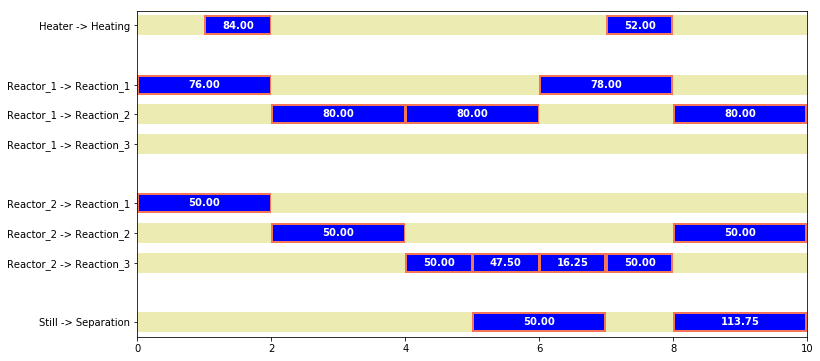

In [802]:
# create instance
m = STN()

# states
m.state("FeedA", init = 200)
m.state("FeedB", init = 200)
m.state("FeedC", init = 200)
m.state("IntBC")
m.state("Product_1", price = 10)
m.state("Product_2", price = 10)

m.STarc("FeedA", "Heating")
m.STarc("FeedB", "Reaction_1", rho = 0.5)
m.STarc("FeedC", "Reaction_1", rho = 0.5)
m.STarc("FeedC", "Reaction_3", rho = 0.2)
m.STarc("HotA", "Reaction_2", rho = 0.4)
m.STarc("IntAB", "Reaction_3", rho = 0.8)
m.STarc("IntBC", "Reaction_2", rho = 0.6)
m.STarc("ImpureE", "Separation")

m.TSarc("Heating", "HotA", 1, 1)
m.TSarc("Reaction_2", "IntAB", rho=0.6, dur=2)
m.TSarc("Reaction_2", "Product_1", rho=0.4, dur=2)
m.TSarc("Reaction_1", "IntBC", dur=2)
m.TSarc("Reaction_3", "ImpureE", dur=1)
m.TSarc("Separation", "IntAB", rho=0.1, dur=2)
m.TSarc("Separation", "Product_2", rho=0.9, dur=1)

m.Unit("Heater", "Heating", 0, 100)
m.Unit("Reactor_1", "Reaction_1", 0, 80)
m.Unit("Reactor_1", "Reaction_2", 0, 80)
m.Unit("Reactor_1", "Reaction_3", 0, 80)
m.Unit("Reactor_2", "Reaction_1", 0, 50)
m.Unit("Reactor_2", "Reaction_2", 0, 50)
m.Unit("Reactor_2", "Reaction_3", 0, 50)
m.Unit("Still", "Separation", 0, 200)

# m.pprint()
m.buildmodel()
m.solve()
m.gantt()
#m.model.pprint()


States at Time 0
    FeedA              200.00
    FeedB              200.00
    FeedC              200.00
    HotA                 0.00
    ImpureE              0.00
    IntAB                0.00
    IntBC                0.00
    Product_1            0.00
    Product_2            0.00

0 Heater Heating
===> 0 Heater Heating
 ==>Time 0 :  Heating Heater
0 Reactor_1 Reaction_1
===> 0 Reactor_1 Reaction_1
 ==>Time 0 :  Reaction_1 Reactor_1
0 Reactor_2 Reaction_1
===> 0 Reactor_2 Reaction_1
 ==>Time 0 :  Reaction_1 Reactor_2
0 Still Separation

New Assignments
Time 0 : Assign unit Heater to task Heating with batch size 100
Time 0 : Transfer 100 from FeedA to Heater

New Assignments
Time 0 : Assign unit Reactor_1 to task Reaction_1 with batch size 80
Time 0 : Transfer 40.0 from FeedB to Reactor_1
Time 0 : Transfer 40.0 from FeedC to Reactor_1

New Assignments
Time 0 : Assign unit Reactor_2 to task Reaction_1 with batch size 50
Time 0 : Transfer 25.0 from FeedB to Reactor_2
Time 0 : Transf

/Users/jeff/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


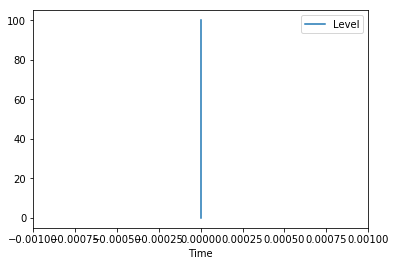

In [717]:
import simpy

env = simpy.Environment()

states = {}
for s in m.states:
    states[s] = state(env,s,capacity=m.C[s],init=m.init[s])

units = {}
for j in m.units:
    units[j] = simpy.Resource(env)

def unitprocess(env,i,j,k):
    yield env.timeout(k)
    with units[j].request() as unit:
        yield unit
        if env.now <= k:
            print(k,j,i)
            B = min([states[s].level/m.rho[(i,s)] for s in m.S[i]])
            B = min(B,m.Vmax[(i,j)])
            feedsAvail = all([(m.rho[(i,s)]*B < states[s].level) for s in m.S[i]]) 
            if feedsAvail and (B >= m.Vmin[(i,j)]):
                print('===>',k,j,i)
                print(' ==>Time', k, ': ',i,j)
                prec = []
                for s in m.S[i]:
                    prec.append(states[s].get(m.rho[(i,s)]*B))
                yield simpy.AllOf(env,prec)
                print('\nNew Assignments')
                print('Time', env.now, ': Assign unit', j, 'to task', i, 'with batch size', B)
                for s in m.S[i]:
                    print('Time', env.now, ': Transfer', m.rho[(i,s)]*B,'from', s, 'to', j)
                prev = 0
                for (t,s) in sorted([(m.P[(i,s)],s) for s in m.S_[i]]):
                    yield env.timeout(t-prev)
                    prev = t
                    yield states[s].put(m.rho_[(i,s)]*B)
                    print('Time', env.now, ': Transfer', m.rho_[(i,s)]*B, "from", j, 'to' ,s)
                print('Time', env.now, ': Release unit', j, 'from task', i)

def reporter(env):
    while True:
        print("\nStates at Time", env.now)
        for s in sorted(states.keys()):
            print('    {0:15s}   {1:7.2f}'.format(s, states[s].level))
        print()
        yield env.timeout(1)
        
env.process(reporter(env))

procs = {}
for k in range(0,11):
    for i in sorted(m.tasks):
        for j in sorted(m.K[i]):
            procs[(i,j,k)] = env.process(unitprocess(env,i,j,k))
            
env.run(until=11)

states['FeedA'].plot()

/Users/jeff/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


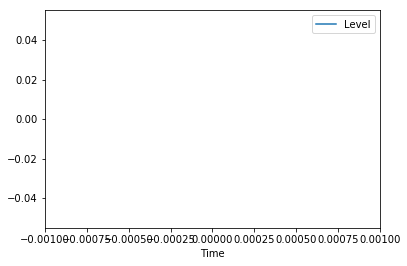

In [702]:
states['Product_2'].plot()